In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

from preprocessing import limpiar_datos, aplicar_dummy_variables_encoding, eliminar_features, entrenar_iterative_imputer, imputar_missings_iterative, reduccion_PCA, normalizar_dataframe, entrenar_normalizador_standard, entrenar_normalizador_minmax
from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV, mapear_target_binario

# K Nearest Neighbors

### Obtención de los datos

Traemos datasets y particionamos

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()


### Definiendo distintos preprocesamientos

Definiremos entonces dos preprocesamientos distintos a comparar para este modelo, y quedarnos con el mejor de ellos cuando probemos en holdout.

In [3]:
def preprocesamiento_1(df_original:pd.DataFrame, imputer=None, normalizador=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    df = aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    
    if(imputer is None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    eliminar_features(df, df.columns.difference(['horas_de_sol', 'humedad_tarde', 'nubosidad_tarde', 'llovieron_hamburguesas_hoy_si', 'llovieron_hamburguesas_hoy_NaN']))
    
    if(normalizador is None):
        normalizador = entrenar_normalizador_standard(df)
    df = normalizar_dataframe(df, normalizador)
    
    return df, imputer, normalizador

Sabiendo que vamos a aplicar KNN, el cuál tiende a dejar de funcionar con dimensionalidad elevada, decidimos que el primer preprocesamiento realice una selección de features que se quede solamente con aquellas que determinamos como importantes en la primera parte del trabajo práctico. Adicionalmente además de realizar las conversiones e imputaciones necesarias, normalizaremos los datos con StandardScaler sabiendo que knn se beneficia de ello.

In [4]:
def preprocesamiento_2(df_original:pd.DataFrame, imputer=None, normalizador=None):
    df = df_original.copy(deep=True)
    df = limpiar_datos(df)
    df = aplicar_dummy_variables_encoding(df, ['llovieron_hamburguesas_hoy'])
    eliminar_features(df, ['dia','barrio', 'direccion_viento_tarde', 'direccion_viento_temprano', 'rafaga_viento_max_direccion'])
    
    if(imputer is None):
        imputer = entrenar_iterative_imputer(df)
    df = imputar_missings_iterative(df, imputer)
    
    if(normalizador is None):
        normalizador = entrenar_normalizador_minmax(df)
    df= normalizar_dataframe(df, normalizador)
    
    df = reduccion_PCA(df, 5)
    
    return df, imputer, normalizador

Para el segundo tipo de preprocesamiento, optaremos por eliminar menos features inicialmente (solo las categóricas que resultaron irrelevantes en la primera parte del TP), para al final del mismo aplicar una reducción de dimensionalidad con el algoritmo PCA. Adicionalmente, probaremos utilizando el normalizador MinMaxScaler en lugar de StandardScaler. Por lo demás, el preprocesamiento se mantiene similar al preprocesamiento 1.

### Aplicamos preprocesamientos 1 y 2 para obtener X_train_1 / X_test_1 y X_train_2 / X_test_2 respectivamente

In [ ]:
X_train_1, imputer_entrenado_1, normalizador_1 = preprocesamiento_1(X_train)
X_test_1, imputer_entrenado_1, normalizador_1 = preprocesamiento_1(X_test, imputer_entrenado_1, normalizador)

In [6]:
X_train_2, imputer_entrenado_2, normalizador_2 = preprocesamiento_2(X_train)
X_test_2, imputer_entrenado_2, normalizador_2 = preprocesamiento_2(X_test, imputer_entrenado_2, normalizador)

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_1

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. Los parametros a optimizar en un modelo KNN son:
- weights: (pesos) La funcion utilizada para asignarle el peso/importancia a cada punto.
- n_neighbors: (vecinos) el número de vecinos que se observan antes de predecir la clase de una instancia nueva.
- metric: La función utilizada para computar la distancia de los puntos

In [7]:
params = {'weights': ['distance', 'uniform'], 'n_neighbors':[5, 10, 15],'metric': ['cosine','euclidean']}
hiperparametros = encontrar_hiperparametros_RGSCV(KNeighborsClassifier(), params=params, x_np=X_train_1, y_np=y_train.to_numpy().ravel())

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [8]:
peso_elegido_1 = hiperparametros['weights']
distancia_elegida_1 = hiperparametros['metric']
k_vecinos_elegido_1 = hiperparametros['n_neighbors']
print(f'Mejor peso: {peso_elegido_1}')
print(f'Mejor tipo de distancia: {distancia_elegida_1}')
print(f'Mejor cantidad de K vecinos: {k_vecinos_elegido_1}')

Mejor peso: uniform
Mejor tipo de distancia: euclidean
Mejor cantidad de K vecinos: 15


### Entrenando el Modelo 1 sobre X_train_1 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [9]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_1, y_train)):
    knn_clasificacion = KNeighborsClassifier(metric=distancia_elegida_1, n_neighbors=k_vecinos_elegido_1, weights=peso_elegido_1)
    knn_clasificacion.fit(X_train_1[train_index], y_train.iloc[train_index].values.ravel())
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], knn_clasificacion.predict(X_train_1[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.95      0.89     15891
   Llueven hamburguesas al dia siguiente       0.69      0.41      0.52      4581

                                accuracy                           0.83     20472
                               macro avg       0.77      0.68      0.71     20472
                            weighted avg       0.81      0.83      0.81     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.90      0.88     15891
   Llueven hamburguesas al dia siguiente       0.58      0.48      0.53      4580

                                accuracy                           0.81     20471
                               macro avg       0.72      0.69      0.70     20471
                            weighted avg       

### Búsqueda de Hiperparámetros para el modelo que entrenará sobre X_train_2

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. Los parametros a optimizar en un modelo KNN son:
- weights: (pesos) La funcion utilizada para asignarle el peso/importancia a cada punto.
- n_neighbors: (vecinos) el número de vecinos que se observan antes de predecir la clase de una instancia nueva.
- metric: La función utilizada para computar la distancia de los puntos

In [10]:
params = {'weights': ['distance', 'uniform'], 'n_neighbors':[5, 10, 15],'metric': ['cosine','euclidean']}
hiperparametros = encontrar_hiperparametros_RGSCV(KNeighborsClassifier(), params=params, x_np=X_train_2, y_np=y_train.to_numpy().ravel())

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [11]:
peso_elegido_2 = hiperparametros['weights']
distancia_elegida_2 = hiperparametros['metric']
k_vecinos_elegido_2 = hiperparametros['n_neighbors']
print(f'Mejor peso: {peso_elegido_2}')
print(f'Mejor tipo de distancia: {distancia_elegida_2}')
print(f'Mejor cantidad de K vecinos: {k_vecinos_elegido_2}')

Mejor peso: uniform
Mejor tipo de distancia: euclidean
Mejor cantidad de K vecinos: 15


### Entrenando el Modelo 2 sobre X_train_2 con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [12]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train_2, y_train)):
    knn_clasificacion = KNeighborsClassifier(metric=distancia_elegida_2, n_neighbors=k_vecinos_elegido_2, weights=peso_elegido_2)
    knn_clasificacion.fit(X_train_2[train_index], y_train.iloc[train_index].values.ravel())
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], knn_clasificacion.predict(X_train_2[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.95      0.90     15891
   Llueven hamburguesas al dia siguiente       0.71      0.41      0.52      4581

                                accuracy                           0.83     20472
                               macro avg       0.78      0.68      0.71     20472
                            weighted avg       0.82      0.83      0.81     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.90      0.88     15891
   Llueven hamburguesas al dia siguiente       0.59      0.49      0.54      4580

                                accuracy                           0.81     20471
                               macro avg       0.72      0.70      0.71     20471
                            weighted avg       

### Predicción del modelo sobre holdout con el modelo que mejor resultó al hacer CrossValidation: Modelo 2

Podemos ver al comparar ambos procesos de CrossValidation, que en general el modelo que usó el preprocesamiento_2 resultó en mejores métricas provistas por el classification report. En promedio, apreciamos un recall mejor, y en consecuencia también un f1 score mucho mejor para este modelo. Vemos además que no hay manifestaciones de overfit, por lo que pasaremos a utilizar el Modelo 2 para predecir sobre el dataset de holdout.

In [14]:
knn_holdout = KNeighborsClassifier(metric=distancia_elegida_2, n_neighbors=k_vecinos_elegido_2, weights=peso_elegido_2)
knn_holdout.fit(X_train_2, y_train.to_numpy().ravel())

KNeighborsClassifier(metric='euclidean', n_neighbors=15)

In [15]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = knn_holdout.predict(X_test_2)
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = knn_holdout.predict_proba(X_test_2)[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.85      0.93      0.89      8828
          si       0.65      0.43      0.52      2545

    accuracy                           0.82     11373
   macro avg       0.75      0.68      0.70     11373
weighted avg       0.80      0.82      0.81     11373



### Curva AUC ROC


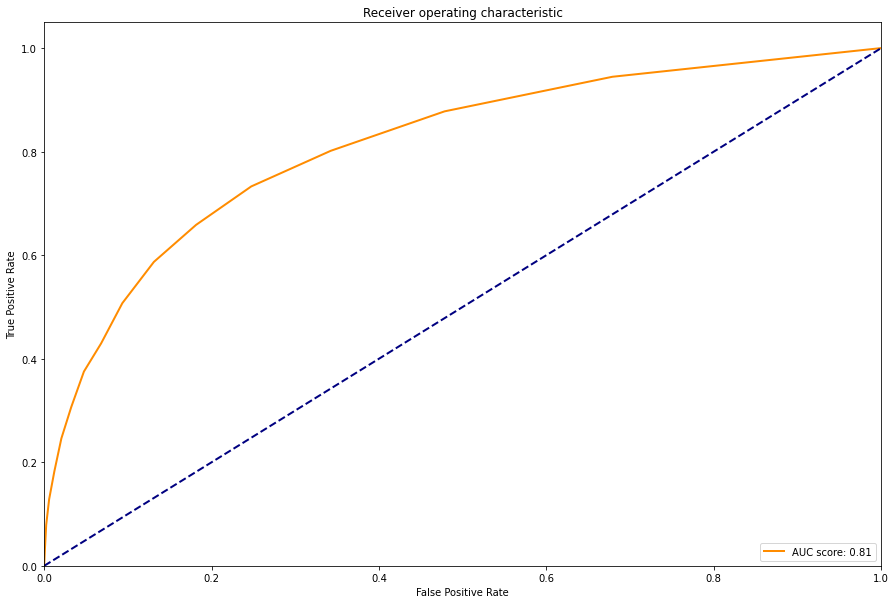

AUC-ROC para este modelo es: 0.8116797063816416


In [16]:
graficar_auc_roc(y_test_binario, y_pred_proba)

Se observa una métrica de auc roc bas

# Matriz de confusion

C:\Users\Guillermo\anaconda3\envs\orgadatos\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


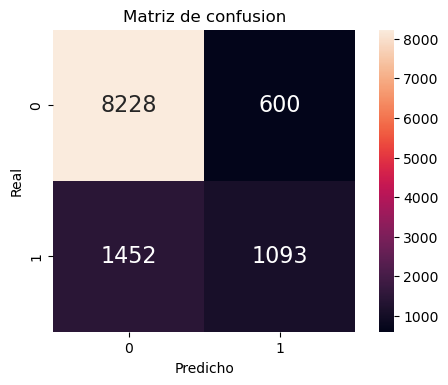

In [17]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el modelo KNN sobre el dataset de predicciones nuevo, y la escribimos al archivo 'KNN.csv'

In [19]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final, imputer_entrenado_2, normalizador = preprocesamiento_2(df_prediccion_final, imputer_entrenado_2, normalizador)

predicciones = knn_holdout.predict(df_prediccion_final)
exportar_prediccion_final(ids, predicciones, 'KNN')